In [2]:
import numpy as np

import matplotlib.pyplot as plt
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional

import hoomd
import hoomd.forward_flux.forward_flux as ffs
import gsd.hoomd

from matplotlib import cm, colors

import sys

In [3]:
sys.path.insert(0, "/home/ian/Projects/work/monk/src")
sys.path

['/home/ian/Projects/work/monk/src',
 '/home/ian/Projects/work/monk/experiments/2d-glass',
 '/home/ian/Projects/work/monk/.venv/lib/python38.zip',
 '/home/ian/Projects/work/monk/.venv/lib/python3.8',
 '/home/ian/Projects/work/monk/.venv/lib/python3.8/lib-dynload',
 '',
 '/home/ian/Projects/work/monk/.venv/lib/python3.8/site-packages']

In [4]:
from monk import nb
from monk import prep
from monk import pair
import freud
import ex_render

In [5]:
def render_sim(sim):
    return ex_render.render_disk_frame(frame=sim.state.get_snapshot())

def render_movie(gsd_file):
    ex_render.display_movie(frame_gen=ex_render.render_disk_frame, gsd_file=gsd_file)

In [6]:
def gen_highT_state():
    seed = 1000
    cpu = hoomd.device.auto_select()
    print(cpu)
    sim = hoomd.Simulation(cpu, seed=seed)
    N = 64
    rng = prep.init_rng(seed + 1)
    L = prep.len_from_phi(N, 1.15, dim=2)
    snap = prep.approx_euclidean_snapshot(N, L, rng, dim=2, ratios=[60,40], diams=[1.0, 0.88])

    sim.create_state_from_snapshot(snap)

    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 1.0, 1.0)
    integrator.forces = [lj]
    integrator.methods = [nvt]

    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)

    sim.operations.integrator = integrator

    sim.run(0)

    print(thermodynamic_properties.pressure)

    for i in range(5):

        sim.run(400_001, True)

        print(i, thermodynamic_properties.pressure)

    hoomd.write.GSD.write(sim.state, "init-state.gsd")

    return render_sim(sim)
    

In [7]:
def dynamic_gsd(temp, seed):
    cpu = hoomd.device.GPU()
    print(cpu)
    sim = hoomd.Simulation(cpu, seed=seed)

    sim.create_state_from_gsd("init-state.gsd")
    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)
    
    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    nvt = hoomd.md.methods.NVT(hoomd.filter.All(), temp, 1.0)
    integrator.forces = [lj]
    integrator.methods = [nvt]

    sim.run(400_000)

    writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename="dynamic-image.gsd", mode="wb", filter=hoomd.filter.All(), dynamic=["property", "momentum"])
    writer_std = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename="static-image.gsd", mode="wb", filter=hoomd.filter.All())
    sim.operations.writers.clear()
    sim.operations.writers.append(writer)
    sim.operations.writers.append(writer_std)

    sim.operations.integrator = integrator

    sim.run(400_001, True)

In [8]:
def simulation_run_msd(temps, seed):
    cpu = hoomd.device.CPU()
    sim = hoomd.Simulation(cpu, seed=seed)

    sim.create_state_from_gsd("init-state.gsd")
    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)
    
    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    for temp in temps:
        nvt = hoomd.md.methods.NVT(hoomd.filter.All(), temp, 1.0)
        integrator.forces = [lj]
        integrator.methods = [nvt]

        writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename=f"long-data/test_T-{temp:.2f}_.gsd", mode="wb", filter=hoomd.filter.All(), dynamic=["property", "momentum"])
        sim.operations.writers.clear()
        sim.operations.writers.append(writer)

        sim.operations.integrator = integrator

        sim.run(4_000_001, True)

In [9]:
def diffusion_coeff(t, msd, dim=2):
    params = np.polyfit(t, msd, 1)
    return params[0]/(2*dim)

In [10]:
def experiment_quench(temps, seed):
    cpu = hoomd.device.CPU()
    sim = hoomd.Simulation(cpu, seed=seed)

    sim.create_state_from_gsd("init-state.gsd")
    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)
    
    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    nvt = hoomd.md.methods.NVT(hoomd.filter.All(), temps[0], 0.25)
    integrator.forces = [lj]
    integrator.methods = [nvt]

    sim.operations.integrator = integrator

    for temp in temps:
        print(temp)
        nvt.kT = temp

        # sim.run(1_000_001)

        writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename=f"long-data-3/test_T-{temp:.2f}_.gsd", mode="wb", filter=hoomd.filter.All(), dynamic=["property", "momentum"])
        sim.operations.writers.append(writer)



        sim.run(400_001, True)

        sim.operations.writers.clear()
        
        

In [44]:
import time

In [67]:
def find_Tg(kT_start, kT_end, steps=4_000_000, equil_steps=40_000, N=16384):

    device = hoomd.device.GPU()

    rng = prep.init_rng(1234)
    L = prep.len_from_phi(N, 1.0, dim=2)
    snap = prep.approx_euclidean_snapshot(N, L, rng, dim=2, ratios=[60,40], diams=[1.0, 0.88])

    sim = hoomd.Simulation(device, seed=0)

    sim.create_state_from_snapshot(snap)
    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)

    variant = hoomd.variant.Ramp(kT_start, kT_end, sim.timestep + equil_steps, steps)

    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    npt = hoomd.md.methods.NPT(hoomd.filter.All(), variant, 0.25, 1.0, 2.5, "xy")
    integrator.forces = [lj]
    integrator.methods = [npt]

    sim.operations.integrator = integrator
    print("starting")
    sim.run(equil_steps)
    print("done equil")
    logger = hoomd.logging.Logger(categories=["scalar"])

    logger.add(thermodynamic_properties)

    writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(4000), filename=f"find_Tg-2.gsd", mode="wb", filter=hoomd.filter.All(), dynamic=["property", "momentum"], log=logger)
    sim.operations.writers.append(writer)

    sim.run(steps, True)

In [68]:
find_Tg(1.0, 0.0)

starting
done equil


In [69]:
traj = gsd.hoomd.open("find_Tg-2.gsd")

In [70]:
traj[0].log

{'md/compute/ThermodynamicQuantities/kinetic_temperature': array([0.9971275]),
 'md/compute/ThermodynamicQuantities/pressure': array([0.97913667]),
 'md/compute/ThermodynamicQuantities/kinetic_energy': array([16335.93982572]),
 'md/compute/ThermodynamicQuantities/translational_kinetic_energy': array([16335.93982572]),
 'md/compute/ThermodynamicQuantities/rotational_kinetic_energy': array([0.]),
 'md/compute/ThermodynamicQuantities/potential_energy': array([-24130.81013457]),
 'md/compute/ThermodynamicQuantities/degrees_of_freedom': array([32766.]),
 'md/compute/ThermodynamicQuantities/translational_degrees_of_freedom': array([32766.]),
 'md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom': array([0.]),
 'md/compute/ThermodynamicQuantities/num_particles': array([16384]),
 'md/compute/ThermodynamicQuantities/volume': array([22601.48347522])}

In [145]:
x = []

y = []

p = []

v = []

for snap in traj[::10]:

    temp = snap.log["md/compute/ThermodynamicQuantities/kinetic_temperature"][0]
    x.append(temp)

    pressure = snap.log["md/compute/ThermodynamicQuantities/pressure"][0]
    volume = snap.log["md/compute/ThermodynamicQuantities/volume"][0]
    p_energy = snap.log["md/compute/ThermodynamicQuantities/potential_energy"][0]
    k_energy = snap.log["md/compute/ThermodynamicQuantities/kinetic_energy"][0]

    H = p_energy + pressure*volume + k_energy
    p.append(pressure)
    v.append(volume)
    y.append(H)


In [149]:
t = np.linspace(1.0, 0.0, 101, endpoint=True)
N=16384

(0.328540607466067, 0.32999999999999996, 1.0182496389055429, 1.144957327858606)

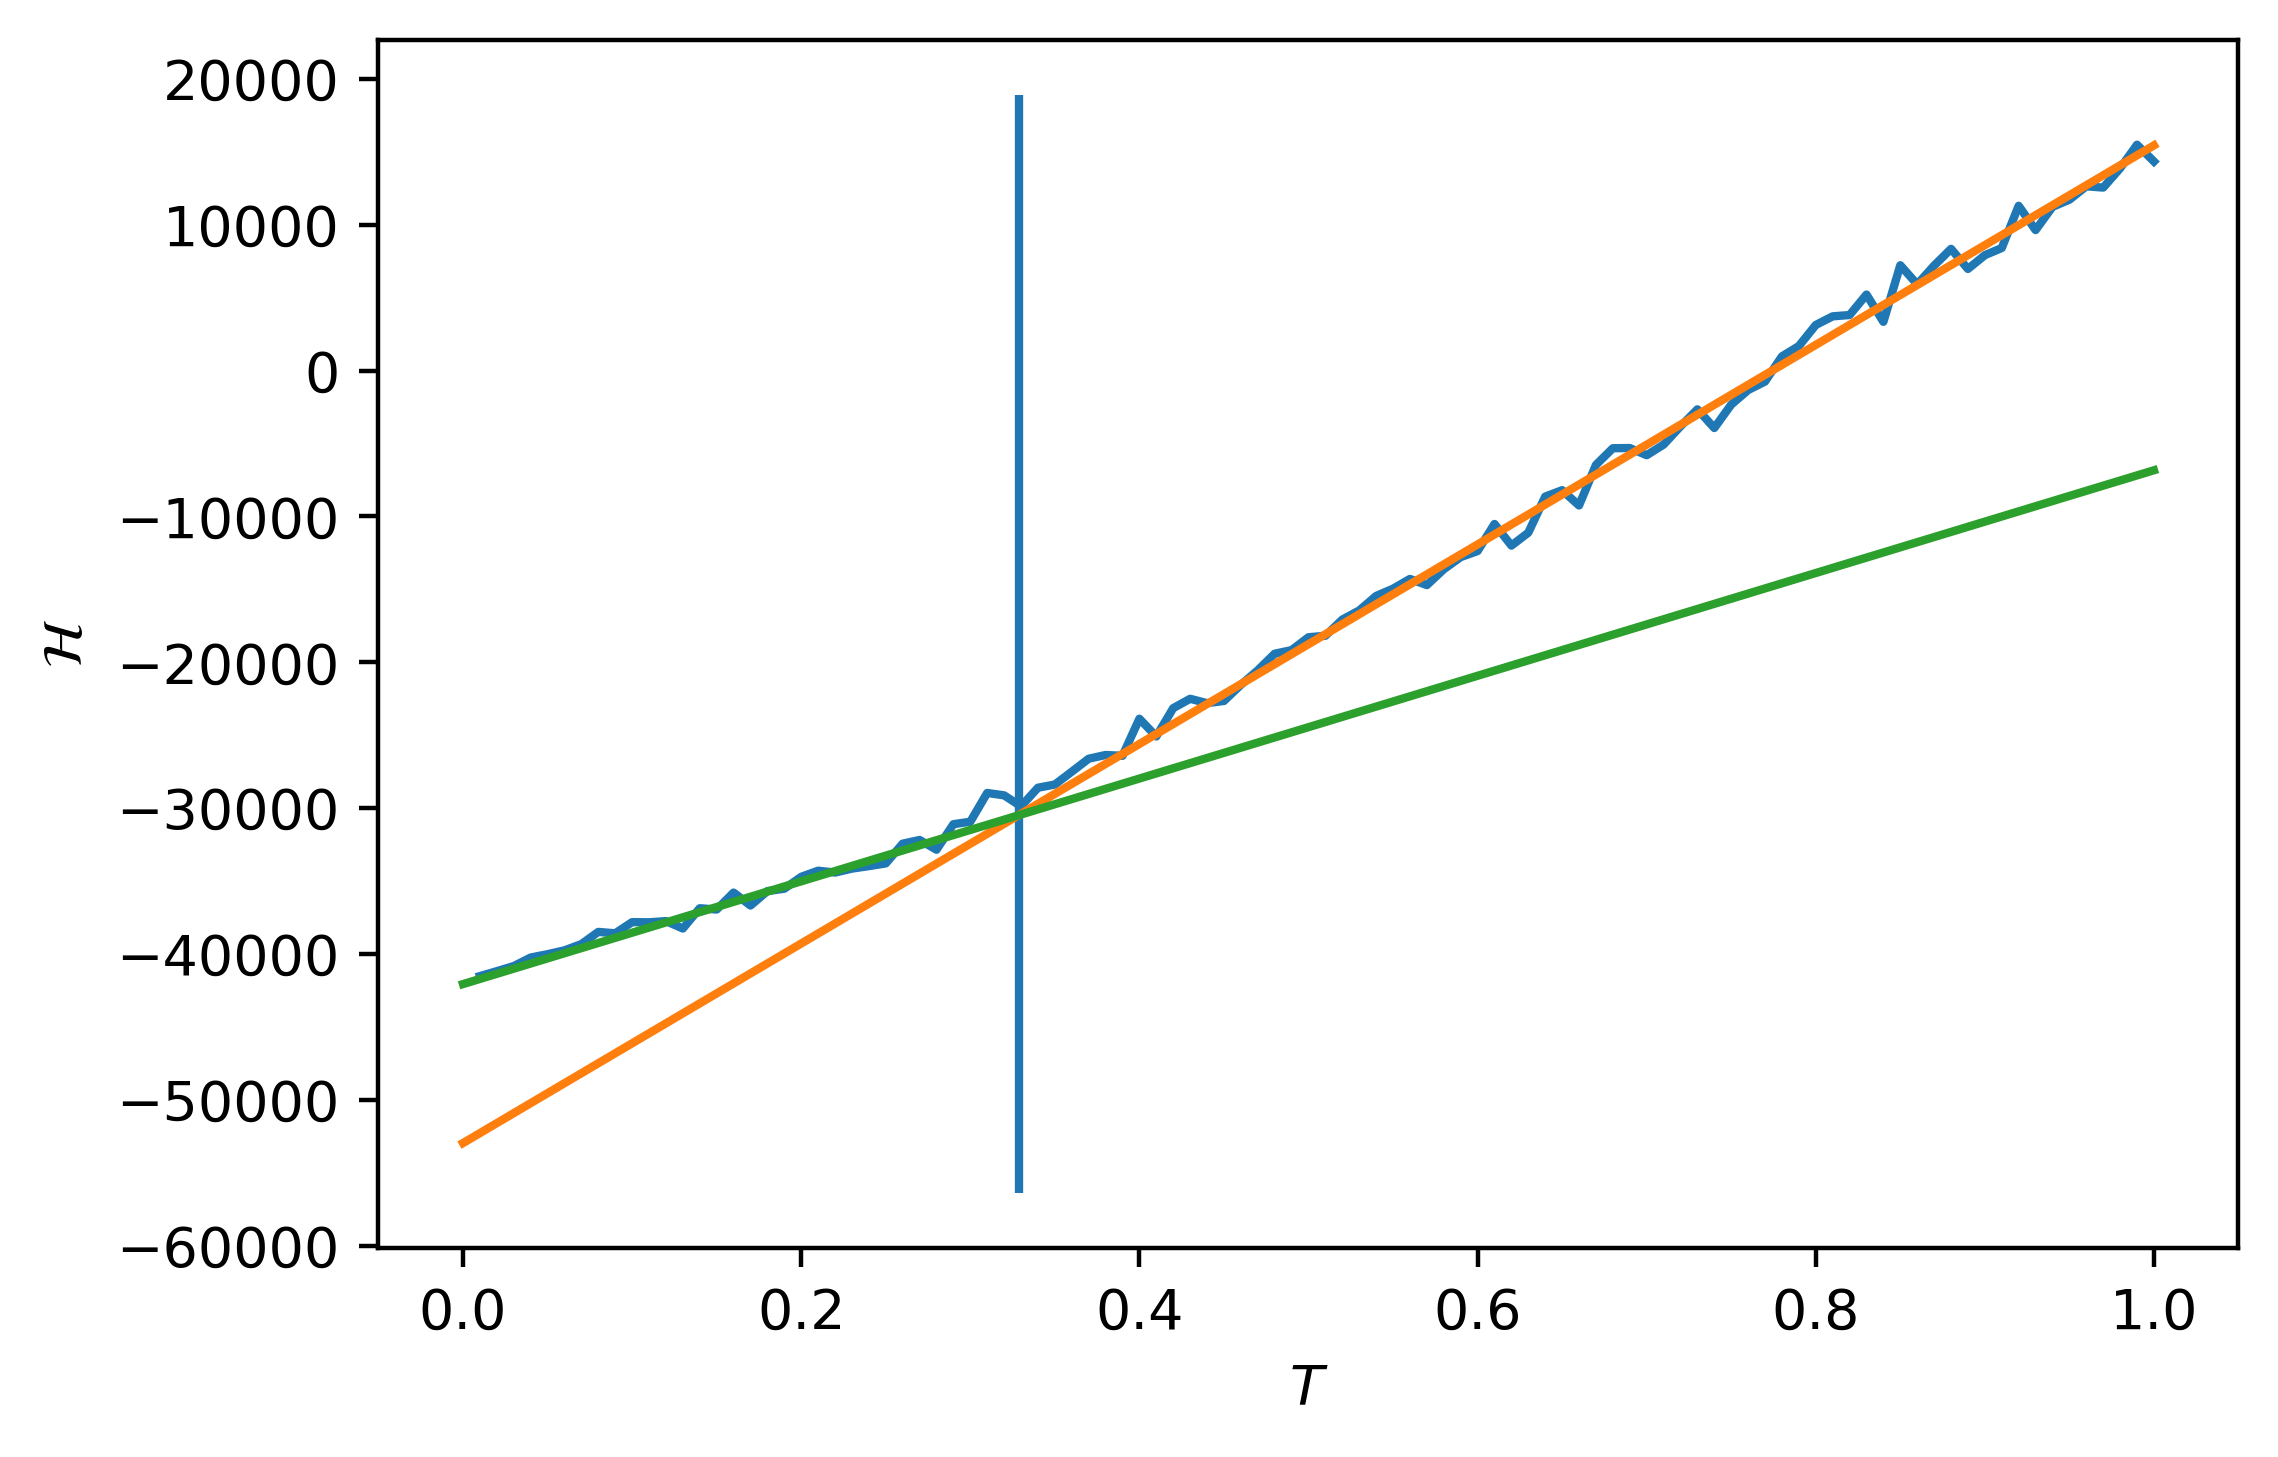

In [151]:
plt.figure(dpi=200)
plt.plot(t, y)
coeff = np.polyfit(t[:50], y[:50], 1)
plt.plot(t, t*coeff[0] + coeff[1])
coeff2 = np.polyfit(t[80:90], np.array(y[80:90]), 1)
plt.plot(t, (t*coeff2[0] + coeff2[1]))
x = -(coeff[1] - coeff2[1])/(coeff[0] - coeff2[0])
plt.vlines(x, *plt.ylim())
plt.ylabel(r"$\mathcal{H}$")
plt.xlabel(r"$T$")

x, t[67], p[68], N/v[67]

In [139]:
coeff2

array([ 35234.63534224, -42072.69289661])

In [120]:
def time_cpu_vs_gpu(steps=4_000):
    devices = [hoomd.device.CPU(), hoomd.device.GPU()]
    Ns = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
    durations = [[], []]
    for N in Ns:
        rng = prep.init_rng(0)
        L = prep.len_from_phi(N, 1.15, dim=2)
        snap = prep.approx_euclidean_snapshot(N, L, rng, dim=2, ratios=[60,40], diams=[1.0, 0.88])
        for i, device in enumerate(devices):

            sim = hoomd.Simulation(device, seed=0)

            sim.create_state_from_snapshot(snap)
            sim.always_compute_pressure = True
            thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
                filter=hoomd.filter.All())
            sim.operations.computes.append(thermodynamic_properties)
            
            integrator = hoomd.md.Integrator(dt=0.0025)
            tree = hoomd.md.nlist.Tree(0.3)
            lj = pair.KA_LJ(tree)
            nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 1.0, 0.25)
            integrator.forces = [lj]
            integrator.methods = [nvt]

            sim.operations.integrator = integrator

            sim.run(0)

            nvt.thermalize_thermostat_dof()
            
            start = time.time()
            sim.run(steps)
            duration = time.time() - start

            durations[i].append(duration)

            del sim
    
    return Ns, durations

In [32]:
Ns, durations = time_cpu_vs_gpu(steps=40)

In [38]:
durations[1]

[0.005757331848144531,
 0.006674289703369141,
 0.006379842758178711,
 0.008473634719848633,
 0.0073621273040771484,
 0.009145021438598633,
 0.012055158615112305,
 0.02016139030456543,
 0.02856159210205078,
 0.05176830291748047,
 0.09245753288269043,
 0.18952536582946777,
 0.3124568462371826,
 0.6586463451385498]

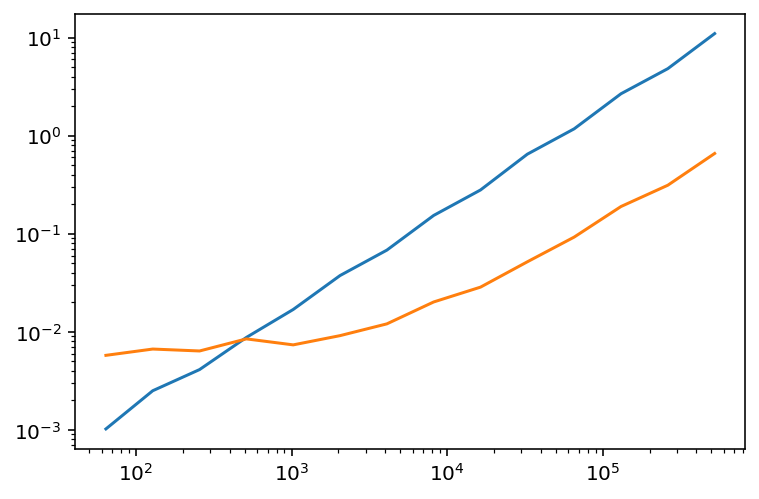

In [34]:
plt.plot(Ns, durations[0])
plt.plot(Ns, durations[1])
plt.yscale('log')
plt.xscale('log')

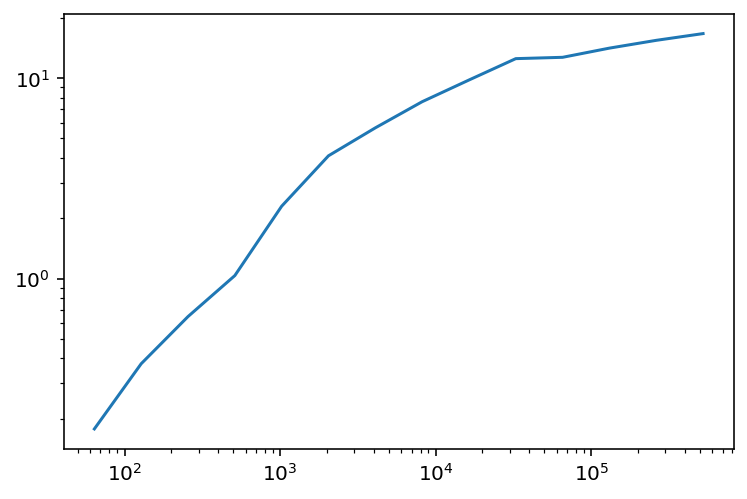

In [35]:
plt.plot(Ns, np.array(durations[0])/np.array(durations[1]))
plt.xscale('log')
plt.yscale('log')

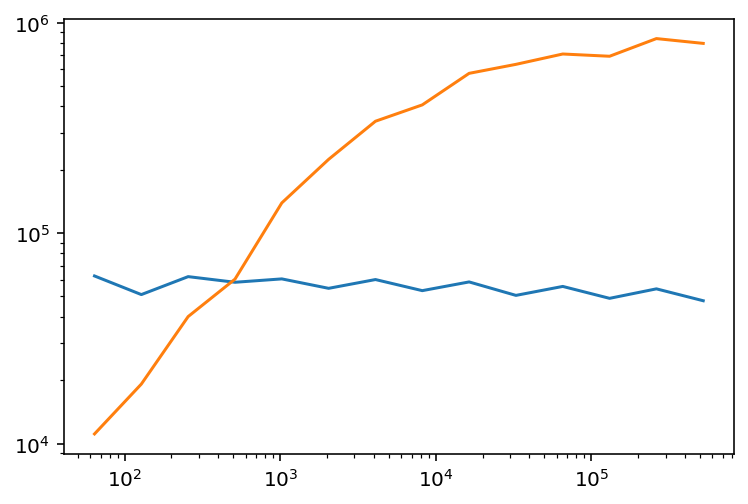

In [36]:
plt.plot(Ns, np.array(Ns)/np.array(durations[0]))
plt.plot(Ns, np.array(Ns)/np.array(durations[1]))
plt.xscale('log')
plt.yscale('log')

27.915922693513103
0 9.812412983938028
1 9.210653618436265
2 6.777905718188988
3 7.296973108132227
4 7.903284585946382


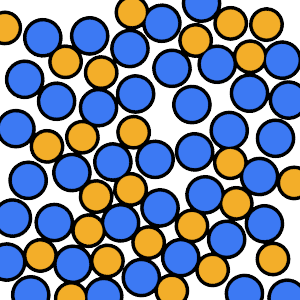

In [17]:
gen_highT_state()

In [81]:
temps = np.linspace(0.5, 0.2, 13)
temps

array([0.5  , 0.475, 0.45 , 0.425, 0.4  , 0.375, 0.35 , 0.325, 0.3  ,
       0.275, 0.25 , 0.225, 0.2  ])

In [83]:
experiment_quench(temps, 123)

0.5
0.475
0.45
0.425
0.4
0.375
0.35
0.325
0.30000000000000004
0.275
0.25
0.22500000000000003
0.2


In [10]:
experiment_quench([1.0], 124)

1.0


(0.01, 20)

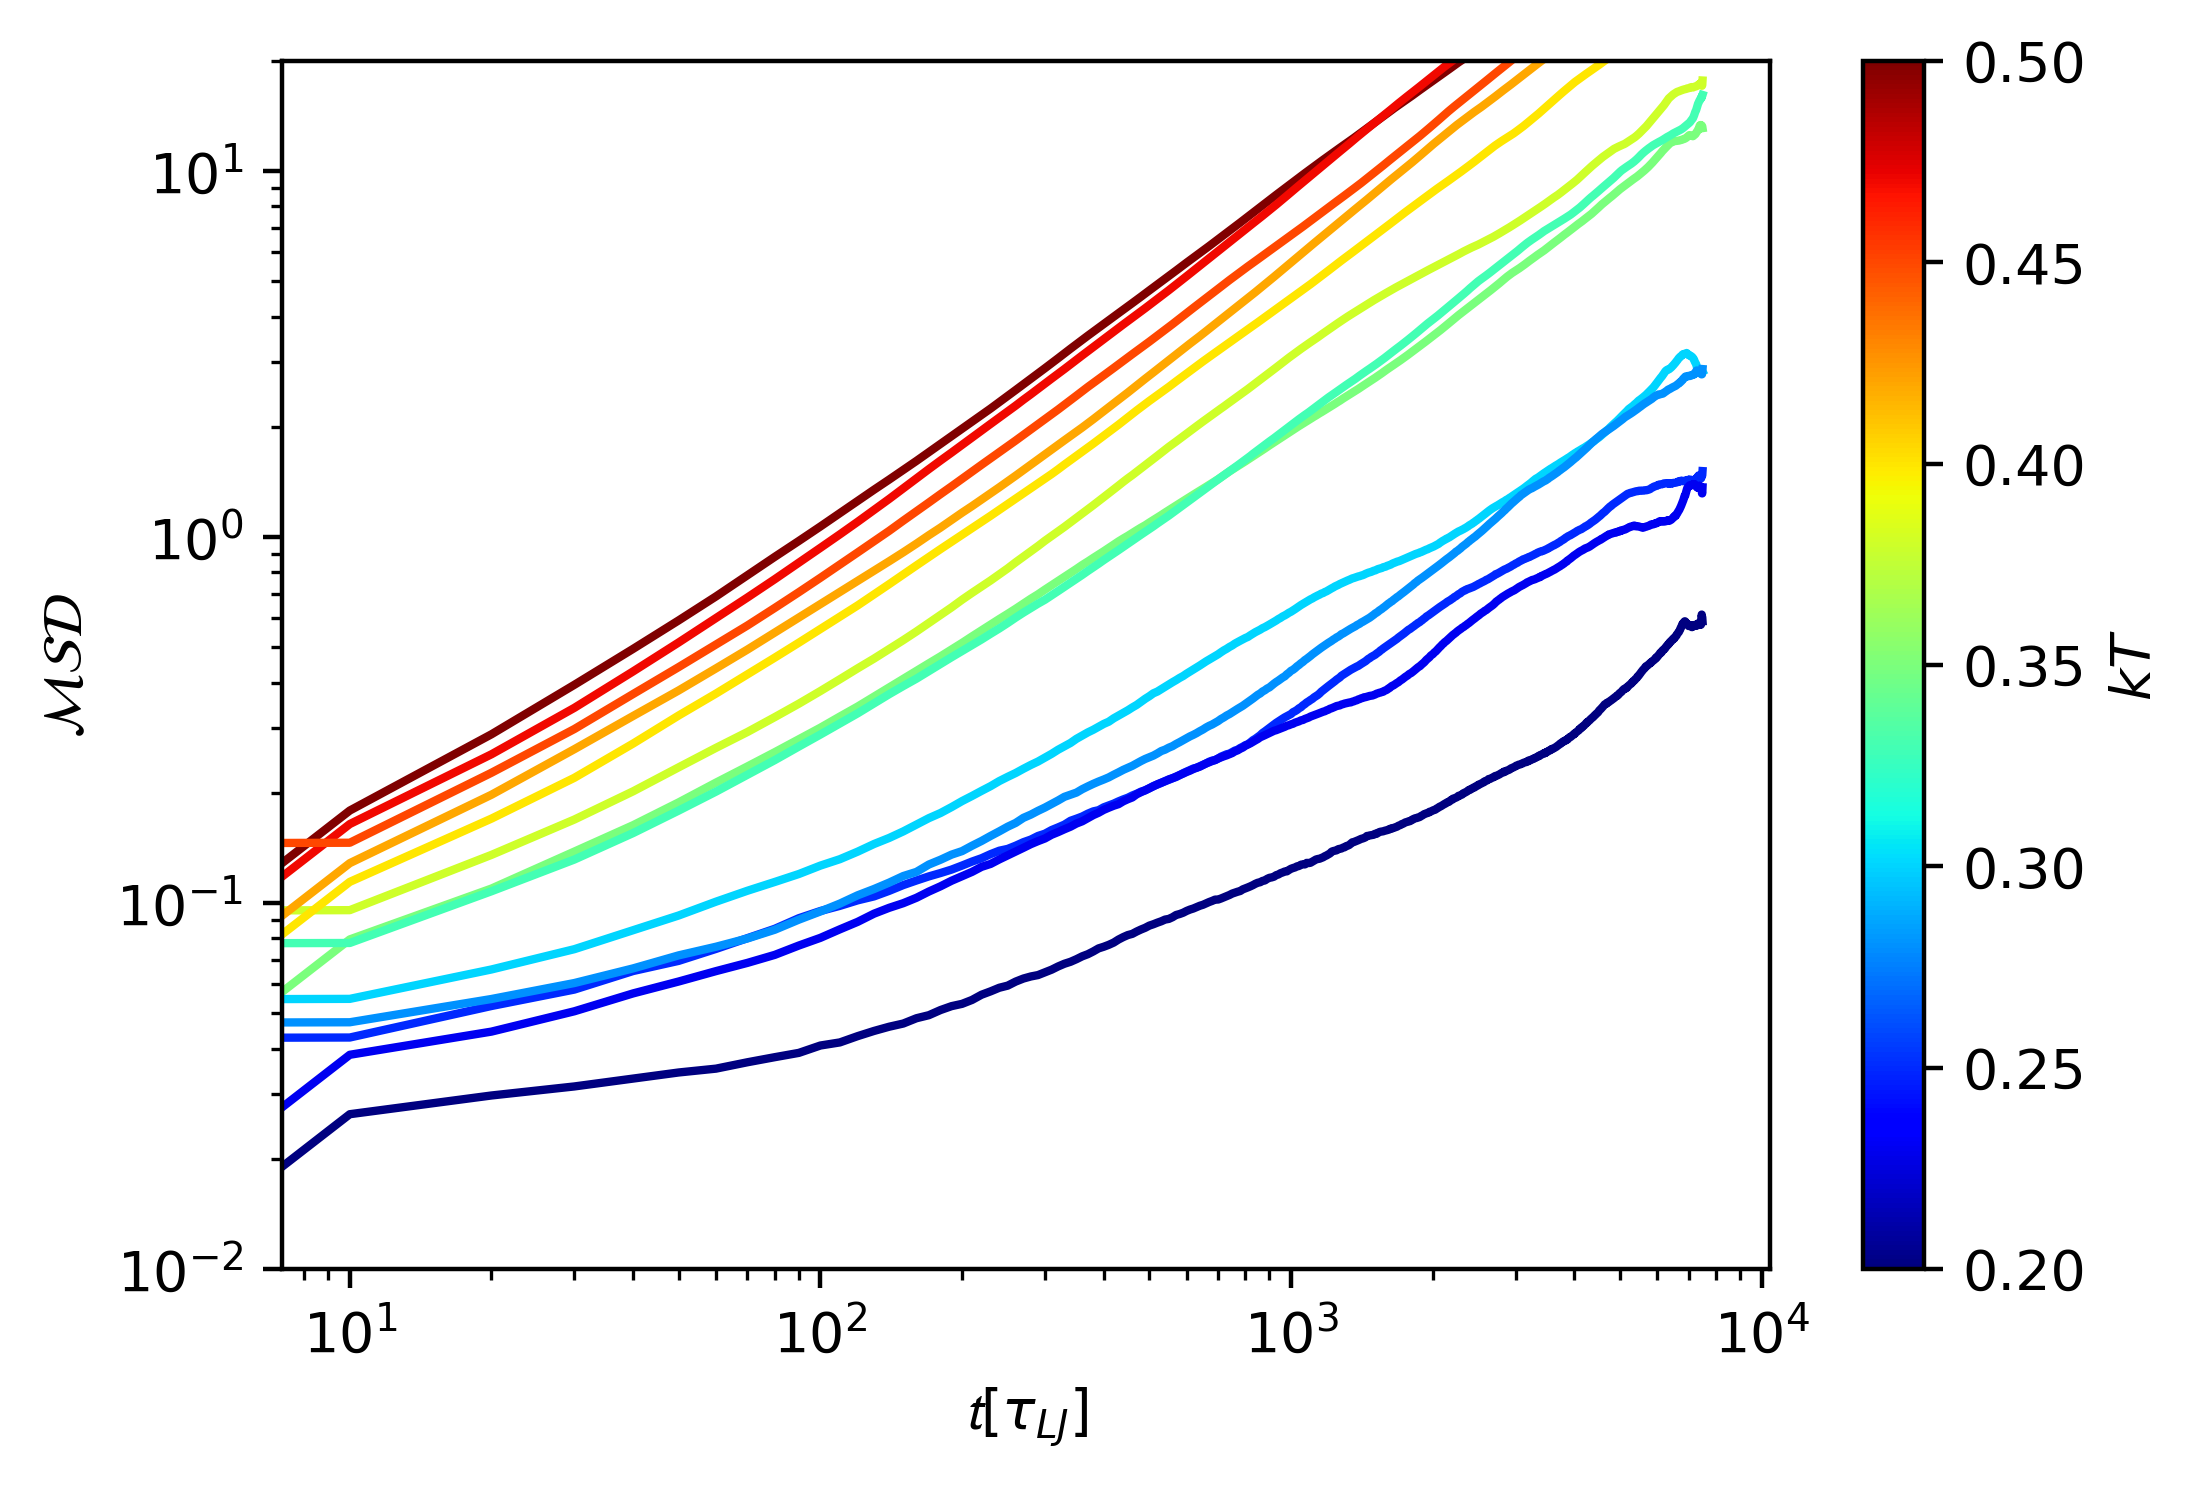

In [97]:
files = glob.glob("long-data-2/*.gsd")
plt.figure(dpi=200)

cmap = cm.jet
norm = colors.Normalize(vmin=0.2, vmax=0.5)
sm = cm.ScalarMappable(norm, cmap)

for file in files:
    traj = gsd.hoomd.open(file)
    box = freud.Box.from_box(traj[0].configuration.box)
    temp = float(file.split('_T-')[-1].split("_")[0])

    # if temp < 0.35:
    #     continue
    msd = freud.msd.MSD()

    pos = []

    t = np.linspace(0, 7500, 750, endpoint=False)

    for frame in traj[::10]:
        pos.append(box.unwrap(frame.particles.position, frame.particles.image))

    msd.compute(pos)
    plt.plot(t, msd.msd, label=f"{temp:.2}", color=cmap(norm(temp)))
plt.xscale('log')
plt.yscale('log')
# plt.legend(bbox_to_anchor=(1,1))
plt.colorbar(sm, label=r"$kT$")
plt.ylabel(r'$\mathcal{MSD}$')
plt.xlabel(r'$\mathcal{t} [\tau_{LJ}]$')
plt.ylim(1e-2, 20)

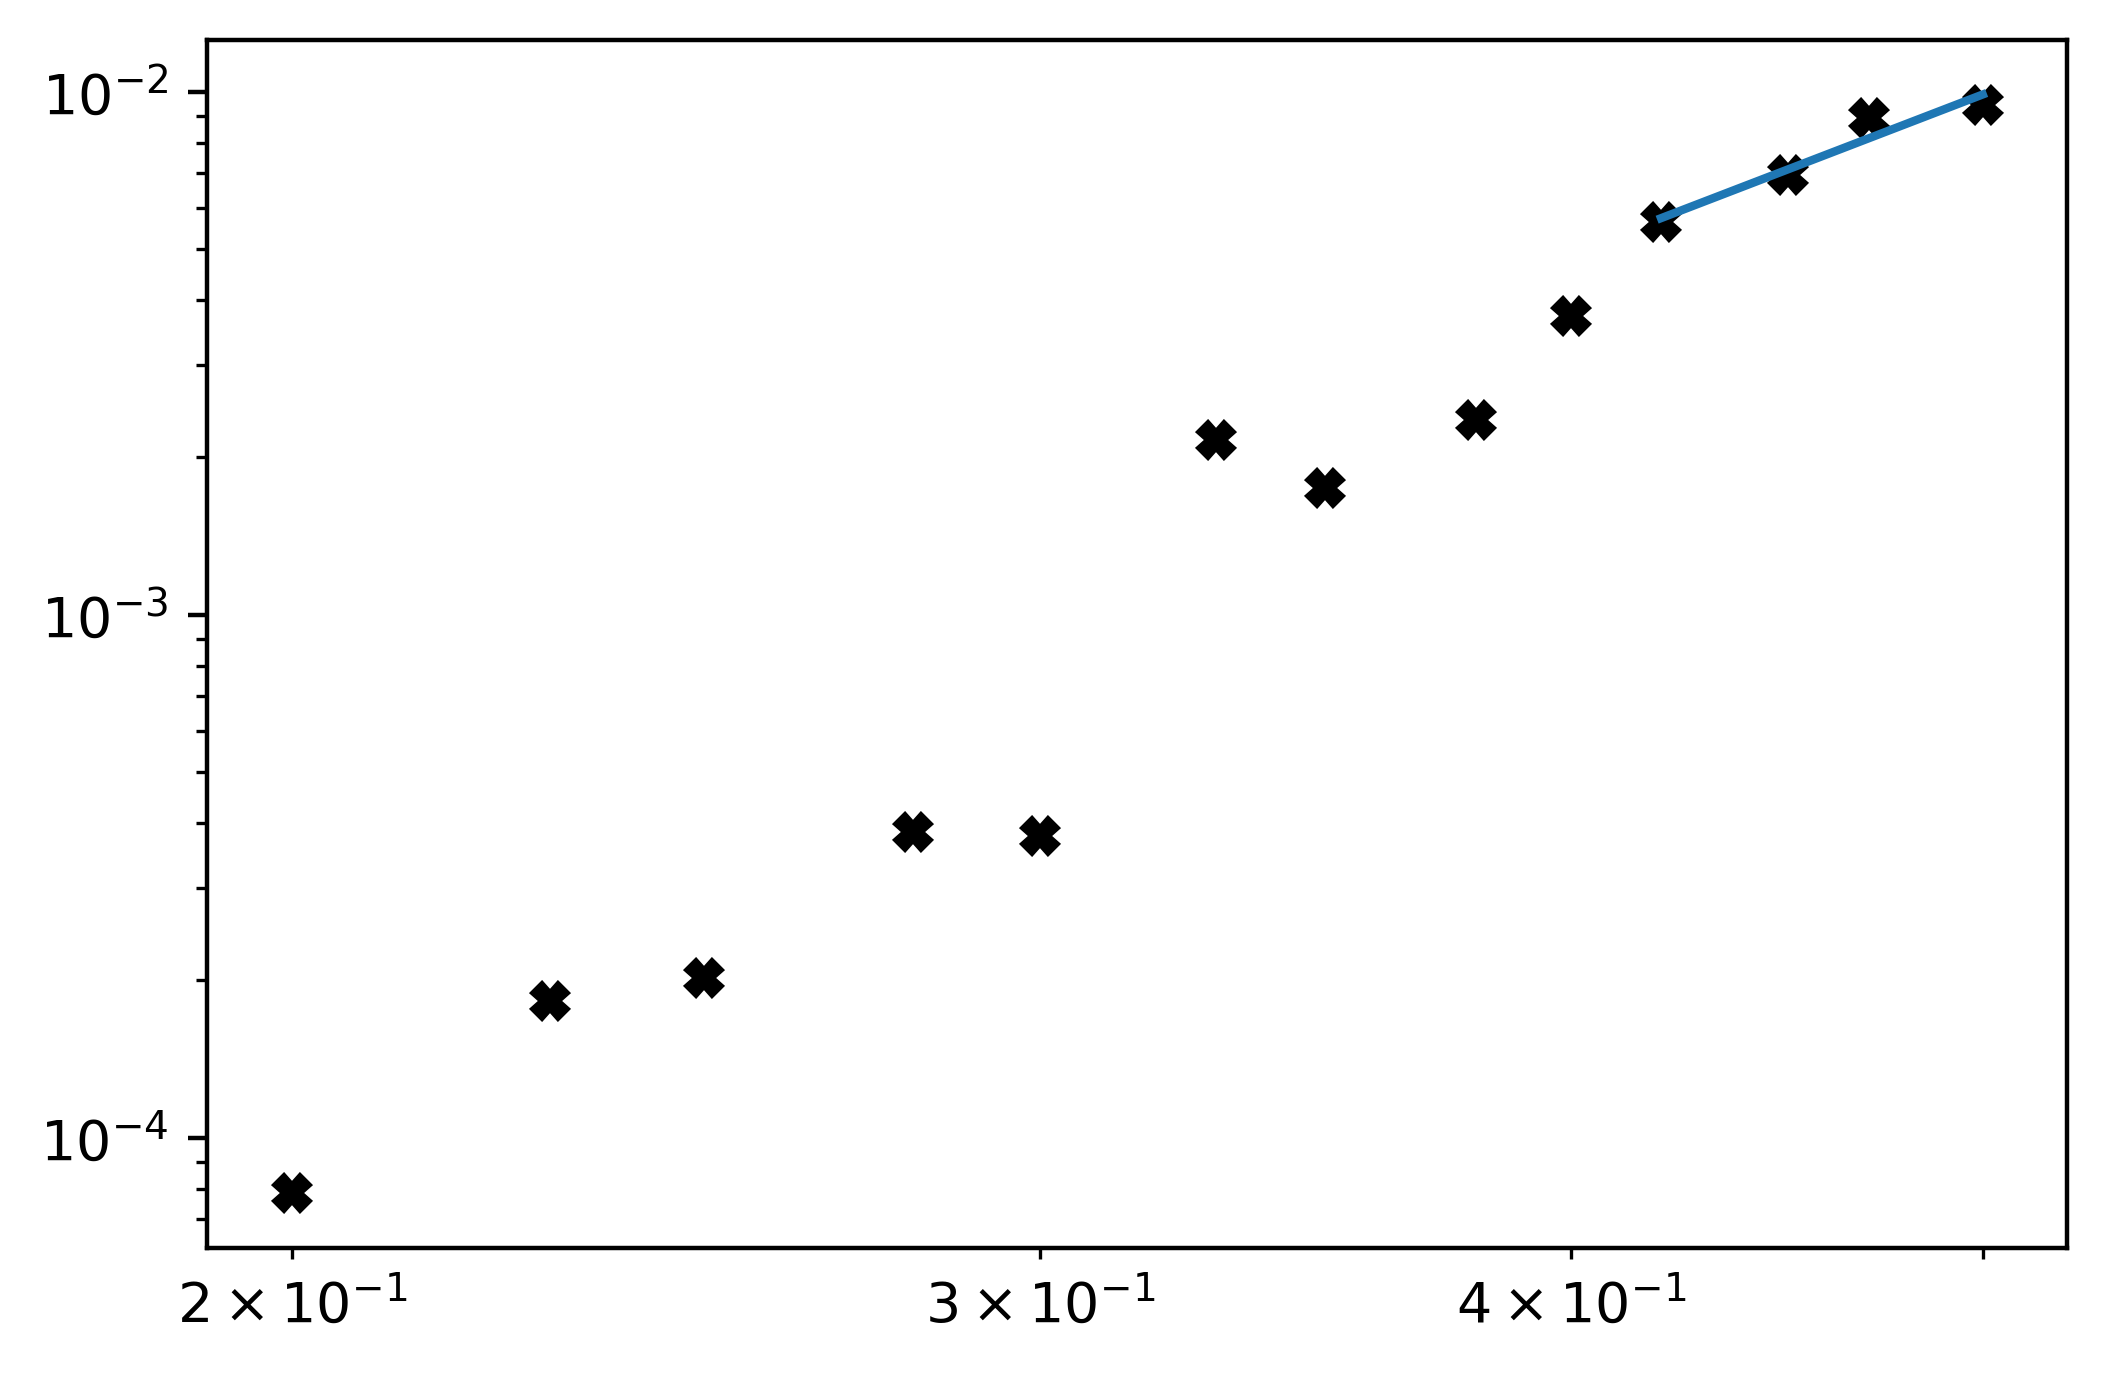

In [101]:
files = glob.glob("long-data-2/*.gsd")
plt.figure(dpi=200)

temps = []
Ds = []



for file in sorted(files):
    traj = gsd.hoomd.open(file)
    temp = float(file.split('_T-')[-1].split("_")[0])
    box = freud.Box.from_box(traj[0].configuration.box)
    msd = freud.msd.MSD()

    if temp < 0.1:
        continue

    pos = []

    t = np.linspace(0, 7500, 750, endpoint=False)

    for frame in traj[::10]:
        pos.append(box.unwrap(frame.particles.position, frame.particles.image))

    msd.compute(pos)
    # D = diffusion_coeff(t, msd.msd)
    D = msd.msd[-1]/t[-1]
    if temp > 0.4:
        temps.append(temp)
        Ds.append(D)

    plt.plot(temp, D, "X", label=f"{temp:.2}", color="k")

temps = np.array(temps)
Ds = np.array(Ds)

params = np.polyfit(np.log(temps), np.log(Ds), 1)
y = np.exp(params[0]*np.log(temps) + params[1])
plt.plot(temps, y)


plt.xscale('log')
plt.yscale('log')
# plt.legend(bbox_to_anchor=(1,1))
# plt.ylim(1e-3, 20)

In [75]:
params

array([ 3.41235173, -5.97952374])

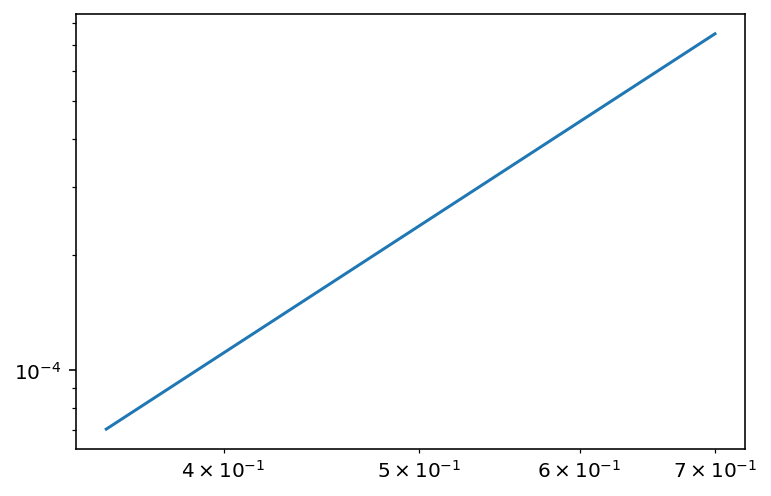

In [73]:
temps = np.array(temps)
Ds = np.array(Ds)

params = np.polyfit(np.log(temps), np.log(Ds), 1)
y = np.exp(params[0]*np.log(temps) + params[1])
plt.plot(temps, y)

plt.yscale('log')
plt.xscale('log')

In [25]:
dynamic_gsd(1.0, 2324)

RuntimeError: No supported GPUs are present on this system.
Failed to get GPU device count: unknown error


In [8]:
dynamic_gsd(1.0, 2324)

In [5]:
traj = gsd.hoomd.open("dynamic-image.gsd")

box = freud.Box.from_box(traj[0].configuration.box)

In [6]:
msd = freud.msd.MSD()

pos = []

for frame in traj[::10]:
    pos.append(box.unwrap(frame.particles.position, frame.particles.image))

msd.compute(pos);

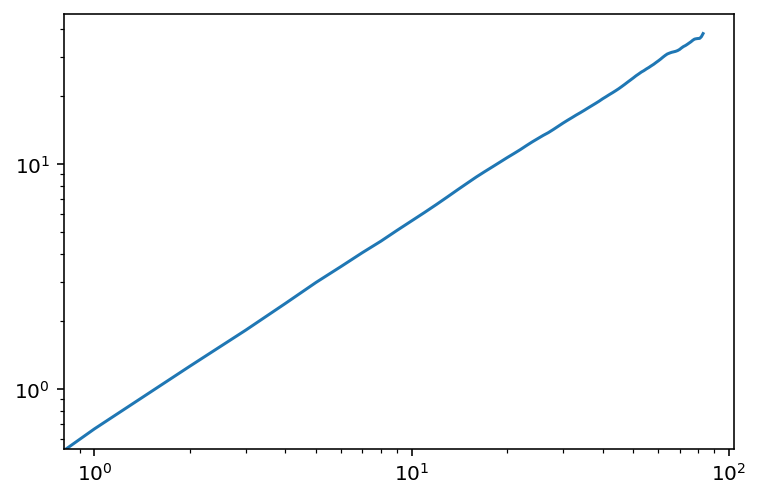

In [7]:
plt.plot(msd.msd)
plt.yscale('log')
plt.xscale('log')